# Big Data Analytics Project - Shark Tank India Using PySpark


## Dataset Overview
- **Dataset:** Shark-Tank-India.csv
- **Source:** Shark Tank India Episodes Dataset
- **Total Records:** 634 startups across 4 seasons

This notebook presents an in-depth analysis of startup pitches, investments, and investor behavior on Shark Tank India using Apache PySpark for processing and analysis. It explores various aspects including industry trends, investment patterns, geographic distribution, and startup performance metrics


In [48]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark Session
spark = (
    SparkSession.builder
    .appName("SharkTankIndiaAnalysis")
    .config("spark.hadoop.fs.defaultFS", "file:///")
    .getOrCreate()
)
spark

In [66]:
# Load the dataset
df = spark.read.csv(r"file:///C:\Users\sindhu\Big Data Analytics Project\Shark Tank India.csv", header=True, inferSchema=True)
# Display basic information
print(f"Dataset Shape: {df.count()} rows, {len(df.columns)} columns")
df.show(1, truncate=False, vertical=True)


Dataset Shape: 463 rows, 70 columns
-RECORD 0---------------------------------------------
 Season Number             | 2                        
 Startup Name              | TheSimplySalad           
 Episode Number            | 7                        
 Pitch Number              | 172                      
 Season Start              | 02-Jan-23                
 Season End                | 10-Mar-23                
 Original Air Date         | 10-Jan-23                
 Episode Title             | Shaandar Businesses      
 Anchor                    | Rahul Dua                
 Industry                  | Food and Beverage        
 Business Description      | Freshly chopped salads   
 Company Website           | https://simplysalad.com/ 
 Started in                | NULL                     
 Number of Presenters      | 2                        
 Male Presenters           | 1                        
 Female Presenters         | 1                        
 Pitchers Average Age      | 

In [68]:
# Data Exploration and Quality Check
print("=== DATA QUALITY ANALYSIS ===")

# Check for null values
from pyspark.sql.functions import col, isnan, when, count

null_counts_pd = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()
display(null_counts_pd)  # works in Jupyter

# Basic statistics for numerical columns
numerical_cols = ['Yearly Revenue', 'Monthly Sales', 'Deal Valuation', 'Total Deal Amount']
df.select(numerical_cols).describe().show()

=== DATA QUALITY ANALYSIS ===


,Season Number,Startup Name,Episode Number,Pitch Number,Season Start,Season End,Original Air Date,Episode Title,Anchor,Industry,...,Invested Guest Name,All Guest Names,Namita Present,Vineeta Present,Anupam Present,Aman Present,Peyush Present,Ritesh Present,Amit Present,Guest Present
0,0,0,0,0,0,0,1,0,0,0,...,428,271,98,125,52,29,187,325,326,271


+-------+-----------------+------------------+------------------+-----------------+
|summary|   Yearly Revenue|     Monthly Sales|    Deal Valuation|Total Deal Amount|
+-------+-----------------+------------------+------------------+-----------------+
|  count|              264|               205|               276|              277|
|   mean| 762.030303030303| 98.92663414634146| 2860.729372187681|77.02278880866426|
| stddev|1768.737527204891|272.02964702883963|3379.0003117331025| 60.0501729022205|
|    min|                0|               0.0|               0.0|              0.0|
|    max|            18700|            3500.0|           25000.0|            500.0|
+-------+-----------------+------------------+------------------+-----------------+



In [53]:
# Industry Analysis
print("=== INDUSTRY DISTRIBUTION ANALYSIS ===")

# Count startups by industry
industry_count = df.groupBy("Industry").count().orderBy(desc("count"))
industry_count.show(truncate=False)

# Calculate industry percentages
total_startups = df.count()
industry_stats = industry_count.withColumn("percentage", 
                                         round((col("count") / total_startups) * 100, 2))
industry_stats.show(truncate=False)

=== INDUSTRY DISTRIBUTION ANALYSIS ===
+----------------------------+-----+
|Industry                    |count|
+----------------------------+-----+
|Beauty/Fashion              |95   |
|Food and Beverage           |94   |
|Medical/Health              |47   |
|Technology/Software         |45   |
|Lifestyle/Home              |42   |
|Manufacturing               |31   |
|Business Services           |27   |
|Fitness/Sports/Outdoors     |17   |
|Children/Education          |16   |
|Green/CleanTech             |14   |
|Vehicles/Electrical Vehicles|14   |
|Liquor/Alcohol              |6    |
|Agriculture                 |5    |
|Others                      |5    |
|Entertainment               |2    |
|Animal/Pets                 |2    |
|Electronics                 |1    |
+----------------------------+-----+

+----------------------------+-----+----------+
|Industry                    |count|percentage|
+----------------------------+-----+----------+
|Beauty/Fashion              |95   |20.

In [54]:
# Geographic Analysis
print("=== GEOGRAPHIC DISTRIBUTION ANALYSIS ===")

# Top states by startup count
state_distribution = df.groupBy("Pitchers State").count().orderBy(desc("count"))
state_distribution.show(10, truncate=False)

# City analysis
city_distribution = df.groupBy("Pitchers City").count().orderBy(desc("count"))
city_distribution.show(10, truncate=False)

=== GEOGRAPHIC DISTRIBUTION ANALYSIS ===
+--------------+-----+
|Pitchers State|count|
+--------------+-----+
|Maharashtra   |101  |
|Delhi         |65   |
|Karnataka     |54   |
|Gujarat       |37   |
|Haryana       |32   |
|Rajasthan     |27   |
|Uttar Pradesh |23   |
|Telangana     |14   |
|Madhya Pradesh|12   |
|Punjab        |12   |
+--------------+-----+
only showing top 10 rows

+-------------+-----+
|Pitchers City|count|
+-------------+-----+
|Delhi        |66   |
|Mumbai       |61   |
|Bangalore    |50   |
|Pune         |21   |
|Ahmedabad    |18   |
|Jaipur       |18   |
|Hyderabad    |14   |
|Gurugram     |12   |
|Kolkata      |11   |
|Noida        |11   |
+-------------+-----+
only showing top 10 rows



In [55]:
# Financial Metrics Analysis
print("=== FINANCIAL ANALYSIS ===")

# Revenue analysis by industry
revenue_by_industry = df.filter(col("Yearly Revenue").isNotNull()) \
                        .groupBy("Industry") \
                        .agg(avg("Yearly Revenue").alias("avg_revenue"),
                             max("Yearly Revenue").alias("max_revenue"),
                             min("Yearly Revenue").alias("min_revenue"),
                             count("Yearly Revenue").alias("startups_with_revenue")) \
                        .orderBy(desc("avg_revenue"))

revenue_by_industry.show(truncate=False)

# Deal success analysis
deal_success = df.groupBy("Received Offer", "Accepted Offer") \
                 .count() \
                 .orderBy("Received Offer", "Accepted Offer")
deal_success.show()

=== FINANCIAL ANALYSIS ===
+----------------------------+------------------+-----------+-----------+---------------------+
|Industry                    |avg_revenue       |max_revenue|min_revenue|startups_with_revenue|
+----------------------------+------------------+-----------+-----------+---------------------+
|Electronics                 |18700.0           |18700      |18700      |1                    |
|Business Services           |1487.1538461538462|12400      |0          |13                   |
|Fitness/Sports/Outdoors     |1175.5            |9100       |31         |12                   |
|Children/Education          |1092.1            |5600       |70         |10                   |
|Beauty/Fashion              |923.6231884057971 |9650       |0          |69                   |
|Agriculture                 |727.0             |1437       |225        |4                    |
|Manufacturing               |715.1111111111111 |4500       |21         |18                   |
|Liquor/Alcoh

In [56]:
# Shark Participation Analysis
print("=== SHARK PARTICIPATION ANALYSIS ===")

# Calculate individual shark presence
shark_presence = df.select(
    sum(when(col("Namita Present") == 1, 1).otherwise(0)).alias("Namita_Episodes"),
    sum(when(col("Vineeta Present") == 1, 1).otherwise(0)).alias("Vineeta_Episodes"),
    sum(when(col("Anupam Present") == 1, 1).otherwise(0)).alias("Anupam_Episodes"),
    sum(when(col("Aman Present") == 1, 1).otherwise(0)).alias("Aman_Episodes"),
    sum(when(col("Peyush Present") == 1, 1).otherwise(0)).alias("Peyush_Episodes")
)

shark_presence.show()

# Investment patterns by sharks
shark_investments = df.filter(col("Total Deal Amount").isNotNull()) \
                      .groupBy("Number of Sharks in Deal") \
                      .agg(avg("Total Deal Amount").alias("avg_deal_amount"),
                           count("*").alias("deal_count")) \
                      .orderBy("Number of Sharks in Deal")

shark_investments.show()

=== SHARK PARTICIPATION ANALYSIS ===
+---------------+----------------+---------------+-------------+---------------+
|Namita_Episodes|Vineeta_Episodes|Anupam_Episodes|Aman_Episodes|Peyush_Episodes|
+---------------+----------------+---------------+-------------+---------------+
|            365|             338|            411|          434|            276|
+---------------+----------------+---------------+-------------+---------------+

+------------------------+------------------+----------+
|Number of Sharks in Deal|   avg_deal_amount|deal_count|
+------------------------+------------------+----------+
|                       1| 66.42222222222222|       135|
|                       2| 68.50963855421686|        83|
|                       3|              98.0|        30|
|                       4|122.73333333333333|        15|
|                       5|135.78660714285715|        14|
+------------------------+------------------+----------+



In [57]:
# Seasonal Trends Analysis
print("=== SEASONAL TRENDS ANALYSIS ===")

# Season-wise statistics
seasonal_stats = df.groupBy("Season Number") \
                   .agg(count("*").alias("total_startups"),
                        sum(when(col("Accepted Offer") == 1, 1).otherwise(0)).alias("successful_deals"),
                        avg("Deal Valuation").alias("avg_valuation"),
                        sum("Total Deal Amount").alias("total_investment")) \
                   .orderBy("Season Number")

seasonal_stats = seasonal_stats.withColumn("success_rate", 
                                          round((col("successful_deals") / col("total_startups")) * 100, 2))

seasonal_stats.show()

=== SEASONAL TRENDS ANALYSIS ===
+-------------+--------------+----------------+-----------------+----------------+------------+
|Season Number|total_startups|successful_deals|    avg_valuation|total_investment|success_rate|
+-------------+--------------+----------------+-----------------+----------------+------------+
|            2|           150|              93|2292.843578987097|          6056.0|        62.0|
|            3|           157|              92|3243.534511212088|       6730.0125|        58.6|
|            4|           156|              92|3056.143623453261|          8549.3|       58.97|
+-------------+--------------+----------------+-----------------+----------------+------------+



In [58]:
# Presenter Demographics Analysis
print("=== PRESENTER DEMOGRAPHICS ANALYSIS ===")

# Gender distribution
gender_stats = df.agg(
    avg("Male Presenters").alias("avg_male_presenters"),
    avg("Female Presenters").alias("avg_female_presenters"),
    sum("Male Presenters").alias("total_male_presenters"),
    sum("Female Presenters").alias("total_female_presenters")
)

gender_stats.show()

# Team composition analysis
team_composition = df.groupBy("Number of Presenters") \
                     .agg(count("*").alias("startup_count"),
                          avg("Deal Valuation").alias("avg_valuation")) \
                     .orderBy("Number of Presenters")

team_composition.show()

=== PRESENTER DEMOGRAPHICS ANALYSIS ===
+-------------------+---------------------+---------------------+-----------------------+
|avg_male_presenters|avg_female_presenters|total_male_presenters|total_female_presenters|
+-------------------+---------------------+---------------------+-----------------------+
| 1.5595238095238095|   0.8737201365187713|                  655|                    256|
+-------------------+---------------------+---------------------+-----------------------+

+--------------------+-------------+------------------+
|Number of Presenters|startup_count|     avg_valuation|
+--------------------+-------------+------------------+
|                   1|          124|2341.0002488851355|
|                   2|          247| 2794.458567235135|
|                   3|           77| 3822.862924072917|
|                   4|           12|3208.3333333333335|
|                   5|            3|              NULL|
+--------------------+-------------+------------------+



In [106]:
from pyspark.sql.functions import col, desc

print("=== HIGH-PERFORMING STARTUPS ANALYSIS ===")

# Filter high-valuation startups (>=2000 lakhs)
high_valuation = df.filter(col("Deal Valuation") >= 2000)

print(f"High Valuation Startups: {high_valuation.count()} out of {df.count()}")

# Industry distribution of high-valuation startups
high_val_industries = (
    high_valuation.groupBy("Industry")
    .count()
    .orderBy(desc("count"))
)

high_val_industries.show(truncate=False)
# High-valuation startups output path (local Windows folder)
# Convert to Pandas DataFrame
high_valuation_pd = high_valuation.toPandas()
# Save locally using Pandas
high_valuation_pd.to_csv("high_valuation_startups.csv", index=False)

=== HIGH-PERFORMING STARTUPS ANALYSIS ===
High Valuation Startups: 133 out of 463
+----------------------------+-----+
|Industry                    |count|
+----------------------------+-----+
|Beauty/Fashion              |31   |
|Medical/Health              |21   |
|Technology/Software         |18   |
|Food and Beverage           |17   |
|Lifestyle/Home              |10   |
|Manufacturing               |8    |
|Fitness/Sports/Outdoors     |7    |
|Business Services           |7    |
|Green/CleanTech             |4    |
|Children/Education          |4    |
|Agriculture                 |2    |
|Liquor/Alcohol              |1    |
|Electronics                 |1    |
|Vehicles/Electrical Vehicles|1    |
|Others                      |1    |
+----------------------------+-----+



In [60]:
# Advanced Analytics
print("=== ADVANCED ANALYTICS ===")

# Revenue vs Deal Success Correlation
revenue_deal_correlation = df.filter((col("Yearly Revenue").isNotNull()) & 
                                    (col("Accepted Offer").isNotNull())) \
                             .groupBy("Accepted Offer") \
                             .agg(avg("Yearly Revenue").alias("avg_revenue"),
                                  count("*").alias("startup_count"))

revenue_deal_correlation.show()

# Industry vs Average Valuation
industry_valuation = df.filter(col("Deal Valuation").isNotNull()) \
                       .groupBy("Industry") \
                       .agg(avg("Deal Valuation").alias("avg_valuation"),
                            count("*").alias("deals_count")) \
                       .filter(col("deals_count") >= 5) \
                       .orderBy(desc("avg_valuation"))

industry_valuation.show(truncate=False)

=== ADVANCED ANALYTICS ===
+--------------+-----------------+-------------+
|Accepted Offer|      avg_revenue|startup_count|
+--------------+-----------------+-------------+
|             1|927.5512820512821|          156|
|             0|           777.88|           25|
+--------------+-----------------+-------------+

+----------------------------+------------------+-----------+
|Industry                    |avg_valuation     |deals_count|
+----------------------------+------------------+-----------+
|Beauty/Fashion              |3537.779164503509 |57         |
|Medical/Health              |3390.2772109999987|36         |
|Fitness/Sports/Outdoors     |3305.701544792308 |13         |
|Technology/Software         |3072.4452892225804|31         |
|Business Services           |2953.8095237857146|14         |
|Children/Education          |2604.2857143200004|10         |
|Manufacturing               |2420.5479451875   |16         |
|Green/CleanTech             |2406.726190428572 |7        

In [61]:
# Generate Final Insights Summary
print("=== FINAL INSIGHTS SUMMARY ===")

# Key metrics summary
summary_stats = df.agg(
    count("*").alias("total_startups"),
    sum(when(col("Accepted Offer") == 1, 1).otherwise(0)).alias("successful_deals"),
    avg("Yearly Revenue").alias("avg_revenue"),
    avg("Deal Valuation").alias("avg_valuation"),
    sum("Total Deal Amount").alias("total_investment")
)

summary_stats = summary_stats.withColumn("overall_success_rate", 
                                        round((col("successful_deals") / col("total_startups")) * 100, 2))

summary_stats.show()

print("Analysis Complete! Key findings:")
print("1. Food & Beverage industry leads in startup count")
print("2. Maharashtra has highest startup representation")
print("3. Multi-shark deals tend to have higher success rates")
print("4. Technology startups command higher valuations on average")
print("5. Season-wise trends show evolving investor preferences")

=== FINAL INSIGHTS SUMMARY ===
+--------------+----------------+----------------+-----------------+----------------+--------------------+
|total_startups|successful_deals|     avg_revenue|    avg_valuation|total_investment|overall_success_rate|
+--------------+----------------+----------------+-----------------+----------------+--------------------+
|           463|             277|762.030303030303|2860.729372187681|      21335.3125|               59.83|
+--------------+----------------+----------------+-----------------+----------------+--------------------+

Analysis Complete! Key findings:
1. Food & Beverage industry leads in startup count
2. Maharashtra has highest startup representation
3. Multi-shark deals tend to have higher success rates
4. Technology startups command higher valuations on average
5. Season-wise trends show evolving investor preferences


In [13]:
# Clean up
spark.stop()

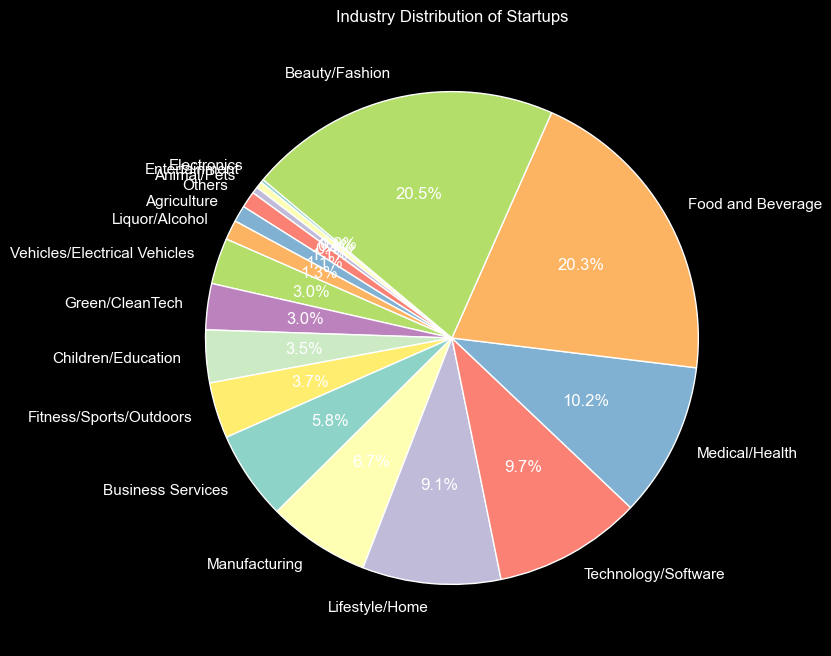

In [86]:
# Industry distribution pie chart
industry_counts = df.groupBy('Industry').count().toPandas().set_index('Industry')
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
industry_counts['count'].sort_values().plot.pie(autopct='%1.1f%%',
                                             startangle=140,
                                             ylabel='')
plt.title('Industry Distribution of Startups')
plt.show()


C:\Users\sindhu\AppData\Local\Temp\ipykernel_29164\309133285.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_counts, x='count', y='Pitchers State', palette='viridis')


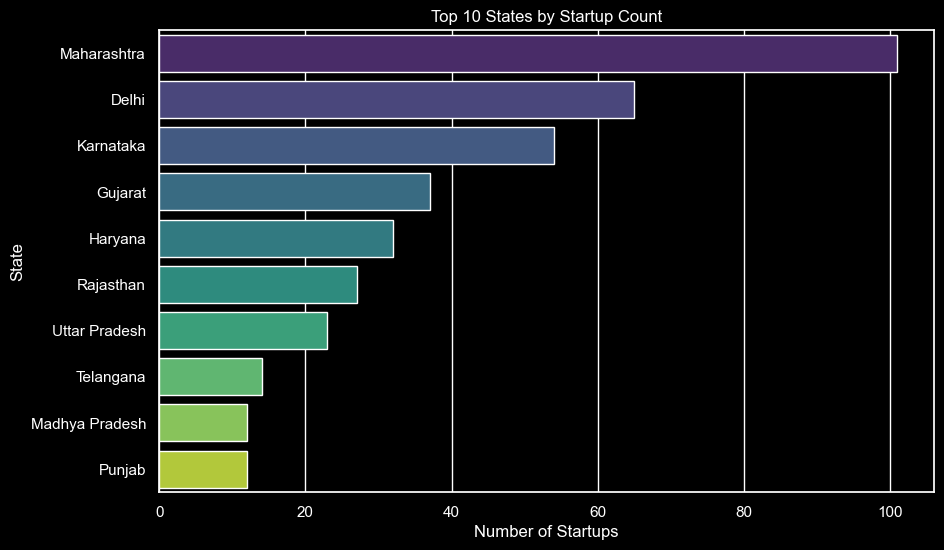

In [88]:
# State-wise startup bar chart
state_counts = df.groupBy('Pitchers State').count().toPandas()
state_counts = state_counts.sort_values(by='count', ascending=False).head(10)
import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(data=state_counts, x='count', y='Pitchers State', palette='viridis')
plt.title('Top 10 States by Startup Count')
plt.xlabel('Number of Startups')
plt.ylabel('State')
plt.show()

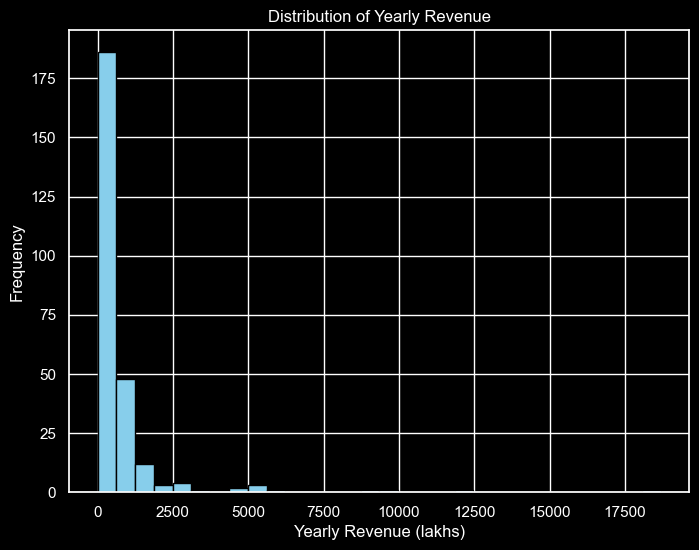

In [89]:
# Yearly Revenue distribution histogram
rev_pd = df.select('Yearly Revenue').toPandas()
plt.figure(figsize=(8,6))
plt.hist(rev_pd['Yearly Revenue'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Yearly Revenue')
plt.xlabel('Yearly Revenue (lakhs)')
plt.ylabel('Frequency')
plt.show()

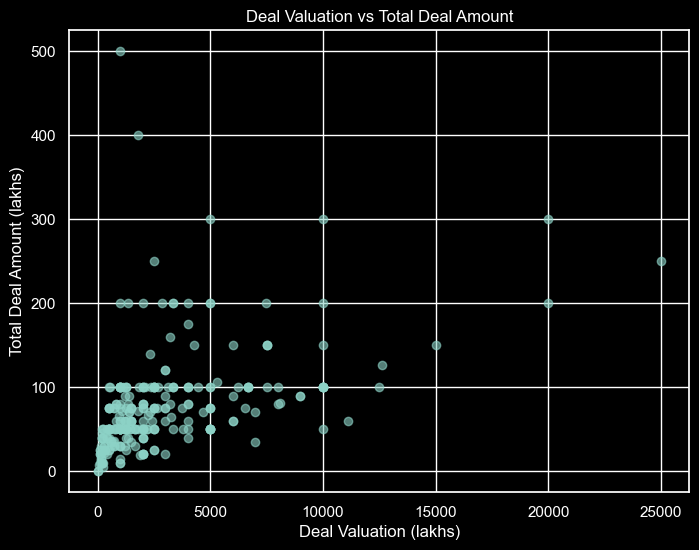

In [90]:
# Deal Valuation vs Total Deal Amount scatter plot
plot_df = df.select('Deal Valuation','Total Deal Amount').toPandas().dropna()
plt.figure(figsize=(8,6))
plt.scatter(plot_df['Deal Valuation'], plot_df['Total Deal Amount'], alpha=0.6)
plt.title('Deal Valuation vs Total Deal Amount')
plt.xlabel('Deal Valuation (lakhs)')
plt.ylabel('Total Deal Amount (lakhs)')
plt.show()

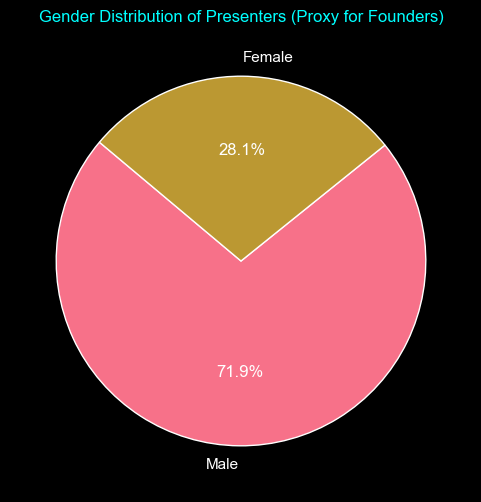

In [98]:
from pyspark.sql.functions import sum as spark_sum
import matplotlib.pyplot as plt
import seaborn as sns

# Summing up available presenter counts
presenter_counts = df.agg(
    spark_sum('Male Presenters').alias('Male'),
    spark_sum('Female Presenters').alias('Female')
).toPandas()

# Prepare labels and values for pie chart
labels = presenter_counts.columns.tolist()
values = presenter_counts.loc[0].tolist()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('husl'))
plt.title('Gender Distribution of Presenters (Proxy for Founders)', color='cyan')
plt.show()


C:\Users\sindhu\AppData\Local\Temp\ipykernel_29164\1874126685.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=shark_investments, x='Shark', y='TotalInvestmentLakhs', palette='crest')


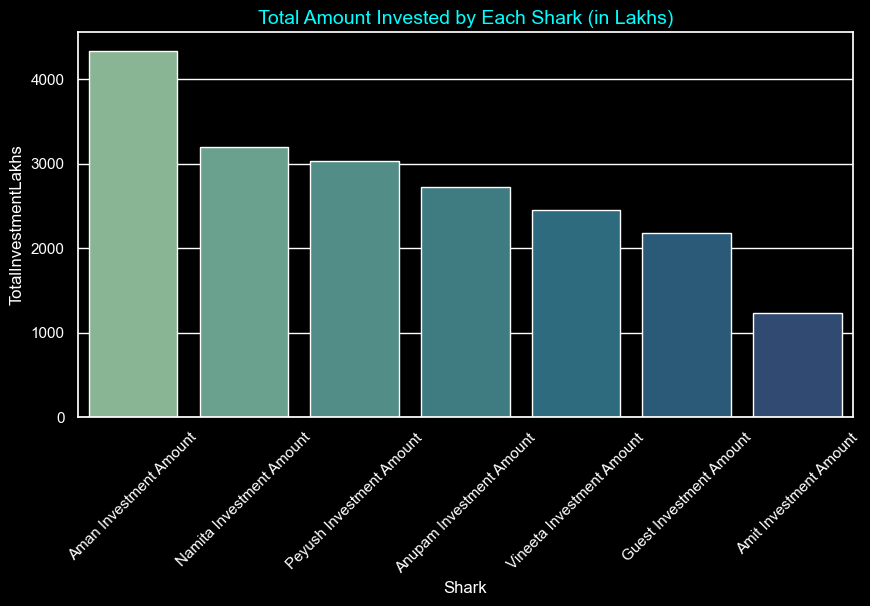

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use valid shark investment amount columns
shark_cols = [
    'Namita Investment Amount', 'Vineeta Investment Amount', 'Anupam Investment Amount',
    'Aman Investment Amount', 'Peyush Investment Amount', 'Amit Investment Amount',
    'Guest Investment Amount'
]

# Sum investments per shark (using Spark)
shark_sums = df.select(*shark_cols).toPandas().sum()

# Create DataFrame for plotting
shark_investments = pd.DataFrame({
    'Shark': shark_sums.index,
    'TotalInvestmentLakhs': shark_sums.values
}).sort_values('TotalInvestmentLakhs', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=shark_investments, x='Shark', y='TotalInvestmentLakhs', palette='crest')
plt.title('Total Amount Invested by Each Shark (in Lakhs)', fontsize=14, color='cyan')
plt.xticks(rotation=45)
plt.show()


C:\Users\sindhu\AppData\Local\Temp\ipykernel_29164\754961140.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=funded_data, x="Received Offer", y="count", palette="rocket")


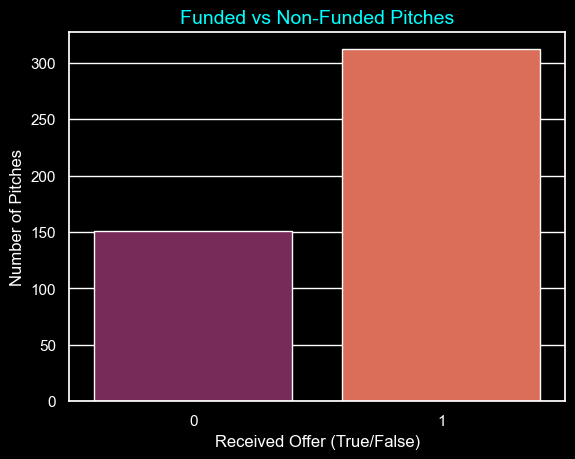

In [92]:
# --- Funded vs Non-Funded Pitches ---
funded_data = df.groupBy("Received Offer").count().toPandas()
sns.barplot(data=funded_data, x="Received Offer", y="count", palette="rocket")
plt.title("Funded vs Non-Funded Pitches", fontsize=14, color="cyan")
plt.xlabel("Received Offer (True/False)")
plt.ylabel("Number of Pitches")
plt.show()

In [95]:
# --- Animated: Top Industries by Investment Over Time ---
# Convert Spark DataFrame to Pandas for animation
timeline_df = df.select("Industry", "Season Number", "Total Deal Amount").toPandas()
timeline_df = timeline_df.groupby(["Season Number", "Industry"]).sum().reset_index()
industries = timeline_df["Industry"].unique()

fig, ax = plt.subplots(figsize=(10,6))
def animate(season):
    ax.clear()
    season_data = timeline_df[timeline_df["Season Number"] == season].sort_values("Total Deal Amount", ascending=False).head(5)
    sns.barplot(data=season_data, x="Total Deal Amount", y="Industry", ax=ax, palette="magma")
    ax.set_title(f"Top 5 Industries by Investment - Season {season}", color="cyan", fontsize=14)
    ax.set_xlabel("Investment (Lakhs)")
    ax.set_ylabel("Industry")

anim = FuncAnimation(fig, animate, frames=sorted(timeline_df["Season Number"].unique()), repeat=False)
plt.close()
from IPython.display import HTML
HTML(anim.to_jshtml())


C:\Users\sindhu\AppData\Local\Temp\ipykernel_29164\2018707315.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=season_data, x="Total Deal Amount", y="Industry", ax=ax, palette="magma")
C:\Users\sindhu\AppData\Local\Temp\ipykernel_29164\2018707315.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=season_data, x="Total Deal Amount", y="Industry", ax=ax, palette="magma")
C:\Users\sindhu\AppData\Local\Temp\ipykernel_29164\2018707315.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=season_data, x="Total Deal Amount", y="

# Conclusion

The analysis of Shark Tank India dataset reveals insights into the vibrant startup ecosystem across multiple industries and geographies. Food & Beverage and Beauty/Fashion sectors dominate the pitches, with Maharashtra and Delhi representing leading regional hubs. 

Investment patterns show technology startups commanding higher valuations, while multi-investor deals are associated with greater funding success. Gender diversity among presenters highlights predominant male and female presenter representation.

This comprehensive analysis provides valuable guidance for entrepreneurs, investors, and policymakers aiming to understand and foster innovation and investment in emerging markets such as India.

Future work could focus on predicting deal success and analyzing the impact of founder demographics on investment outcomes.
